## **Import Libraries**

In [1]:
import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

## **Explore the Environment**

In [2]:
import gym

env = gym.make('MountainCar-v0')
print("The observation space: {}".format(env.observation_space.shape))
print("The action space: {}".format(env.action_space))

The observation space: (2,)
The action space: Discrete(3)


In [3]:
print(env.observation_space.high)
print(env.observation_space.low)

[0.6  0.07]
[-1.2  -0.07]


## **Plot Function**

In [4]:
# Plot function to visualize Rewards per Episodes 
# and Time-Steps per Episodes .

def plot_episode_stats(rewards, steps, noshow=False):
    # Rewards per episode
    fig1 = plt.figure(figsize=(20,5))
    plt.plot(rewards)
    plt.xlabel("Episodes")
    plt.ylabel("Rewards")
    plt.title("Rewards per Episodes")
    if noshow:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Time-steps per episode
    fig2 = plt.figure(figsize=(20,5))
    plt.plot(steps)
    plt.xlabel("Episodes")
    plt.ylabel("Time-Steps")
    plt.title("Time-Steps per Episodes")
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)
        
    return fig1, fig2

In [5]:
# Plot function that highlight the optimal performance(maximum return in an episode/
# minimum number of time-steps per episode) in dotted line.

def plot_episode_stats_max(rewards, steps, max_reward, min_step, noshow=False):
    # Rewards per episode
    fig1 = plt.figure(figsize=(20,5))
    plt.plot(rewards)
    plt.hlines(y=np.max(max_reward), xmin=0, xmax=max_num_episodes/10, colors='black', linestyles='--', lw=2)
    plt.plot(max_reward, marker='o')
    plt.xlabel("Episodes")
    plt.ylabel("Rewards")
    plt.title("Rewards per Episodes")
    if noshow:
        plt.close(fig1)
    else:
        plt.show(fig1)
        print('Maximum reward = ',np.max(max_reward))

    # Time-steps per episode
    fig2 = plt.figure(figsize=(20,5))
    plt.plot(steps)
    plt.hlines(y=np.min(min_step), xmin=-0, xmax=max_num_episodes/10, colors='black', linestyles='--', lw=2)

    plt.plot(min_step, marker='o')
    plt.xlabel("Episodes")
    plt.title("Time-Steps per Episodes")
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)
        print('Minimum step = ',np.min(min_step))
        
    return fig1, fig2

In [6]:
max_num_episodes = 1000
steps_per_episodes = 200 # This is specific to MountainCar. May change with env
epsilon_min = 0.005
max_num_steps = max_num_episodes * steps_per_episodes
epilon_decay = 500 * epsilon_min / max_num_steps
num_discrete_bins = 30 # Number of bins to Discretize each observation dim 30


class Q_Learning(object):
    
    def __init__(self, env, alpha, gamma, epsilon):
        self.obs_shape = env.observation_space.shape
        self.obs_high = env.observation_space.high
        self.obs_low = env.observation_space.low
        # Number of bins to Discretize each observation dim
        self.obs_bins = num_discrete_bins
        self.bin_width = (self.obs_high - self.obs_low) / self.obs_bins
        self.action_shape = env.action_space.n
        # Create a multi-dimensional array (aka. Table) to represent the Q-values
        # (51 x 51 x 3)
        self.Q = np.zeros((self.obs_bins + 1, self.obs_bins + 1,self.action_shape))  
        # Learning rate
        self.alpha = alpha  
        # Discount factor
        self.gamma = gamma  
        self.epsilon = epsilon

    def discretize(self, obs):
        
        return tuple(((obs - self.obs_low) / self.bin_width).astype(int))

    def get_action(self, obs):
        
        discretized_obs = self.discretize(obs)
        # Epsilon-Greedy action selection
        if self.epsilon > epsilon_min:
            self.epsilon -= epilon_decay
        if np.random.random() > self.epsilon:
            return np.argmax(self.Q[discretized_obs])
        else:  
            # Choose a random action
            return np.random.choice([a for a in range(self.action_shape)])

    def learn(self, obs, action, reward, next_obs):
        
        discretized_obs = self.discretize(obs)
        discretized_next_obs = self.discretize(next_obs)
        td_target = reward + self.gamma * np.max(self.Q[discretized_next_obs])
        td_error = td_target - self.Q[discretized_obs][action]
        self.Q[discretized_obs][action] += self.alpha * td_error
        # we can write the Q-learning update rule in one line of code as written below
        #  self.Q[discretized_obs][action] += self.alpha * (reward + self.gamma * 
        #    np.max(self.Q[discretized_next_obs])) - self.Q[discretized_obs][action]

In [7]:
m_r=[]                    # mean of rewards
m_s=[]                    # mean of steps
m_r_max=[]                # maximum of mean reward
m_s_min= []               # minimum of mean steps

def train(agent, env):
    
    env = gym.make('MountainCar-v0')
    agent = Q_Learning(env,alphas,gamma,epsilon)
    
    rewards = []
    steps = []
    
    tot_reward=[]
    ss=[]
    
    re_avg=[]
    re_max=[]
    
    ss_avg=[]
    ss_min=[]
    
    best_reward = -float('inf')
    
    for episode in range(max_num_episodes):
        done = False
        obs = env.reset()
        total_reward = 0.0
        step = 0
        
        while not done:
            action = agent.get_action(obs)
            next_obs, reward, done, info = env.step(action)
            agent.learn(obs, action, reward, next_obs)
            obs = next_obs
            total_reward += reward
            step += 1
            
        if total_reward > best_reward:
            best_reward = total_reward
            
        policy= np.argmax(agent.Q, axis=2)   

        
        tot_reward.append(total_reward)
        ss.append(step)
        
        if (episode+1) % 10 == 0: 
            
            re_avg.append(np.array(tot_reward).mean())
            ss_avg.append(np.array(ss).mean())
            re_max.append(np.array(tot_reward).max())
            ss_min.append(np.array(ss).min())
            
            rew=[]
            stp=[]
            
#             gym_monitor_path = "./gym_monitor_output"
#             env = gym.wrappers.Monitor(env, gym_monitor_path, force=True)

            for i in range(5):
        
                    re_test,st_test= test(agent, env, policy)
                    
                    rew.append(re_test)
                    stp.append(st_test)
 
            m_r.append(np.array(rew).mean())
            m_s.append(np.array(stp).mean())
            m_r_max.append(np.array(rew).max())
            m_s_min.append(np.array(stp).min())

        print("Episode#:{} reward:{} best_reward:{} eps:{} TimeStep:{}".format(episode,total_reward, best_reward, agent.epsilon, step))
            
        rewards.append(total_reward)
        steps.append(step)      
    plot_episode_stats(rewards, steps)
    plot_episode_stats_max(re_avg, ss_avg, re_max, ss_min)
    plot_episode_stats_max(m_r, m_s, m_r_max, m_s_min)



In [8]:
def test(agent, env, policy):
    done = False
    obs = env.reset()
    total_reward = 0.0
    stepp=0
    
    while not done:
        action = policy[agent.discretize(obs)]
        next_obs, reward, done, info = env.step(action)
        obs = next_obs
        total_reward += reward
        stepp+=1
    return total_reward,stepp

Episode#:0 reward:-200.0 best_reward:-200.0 eps:0.09750000000000028 TimeStep:200
Episode#:1 reward:-200.0 best_reward:-200.0 eps:0.09500000000000056 TimeStep:200
Episode#:2 reward:-200.0 best_reward:-200.0 eps:0.09250000000000083 TimeStep:200
Episode#:3 reward:-200.0 best_reward:-200.0 eps:0.0900000000000011 TimeStep:200
Episode#:4 reward:-200.0 best_reward:-200.0 eps:0.08750000000000138 TimeStep:200
Episode#:5 reward:-200.0 best_reward:-200.0 eps:0.08500000000000166 TimeStep:200
Episode#:6 reward:-200.0 best_reward:-200.0 eps:0.08250000000000193 TimeStep:200
Episode#:7 reward:-200.0 best_reward:-200.0 eps:0.08000000000000221 TimeStep:200
Episode#:8 reward:-200.0 best_reward:-200.0 eps:0.07750000000000248 TimeStep:200
Episode#:9 reward:-200.0 best_reward:-200.0 eps:0.07500000000000276 TimeStep:200
Episode#:10 reward:-200.0 best_reward:-200.0 eps:0.07250000000000303 TimeStep:200
Episode#:11 reward:-200.0 best_reward:-200.0 eps:0.07000000000000331 TimeStep:200
Episode#:12 reward:-200.0 b

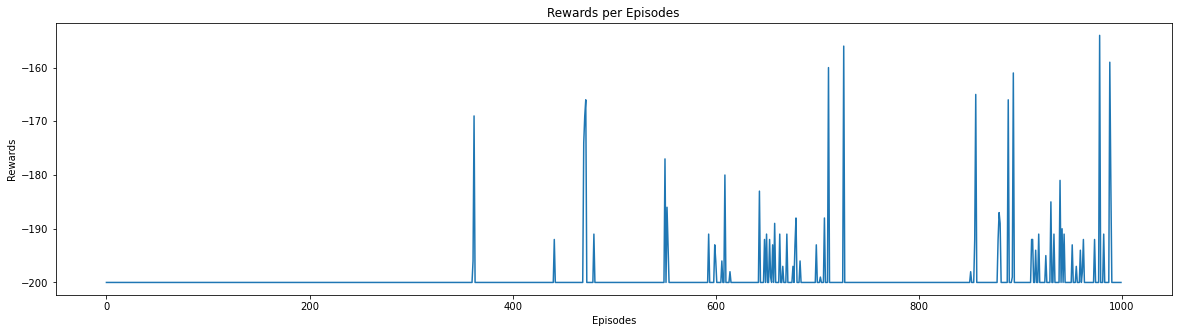

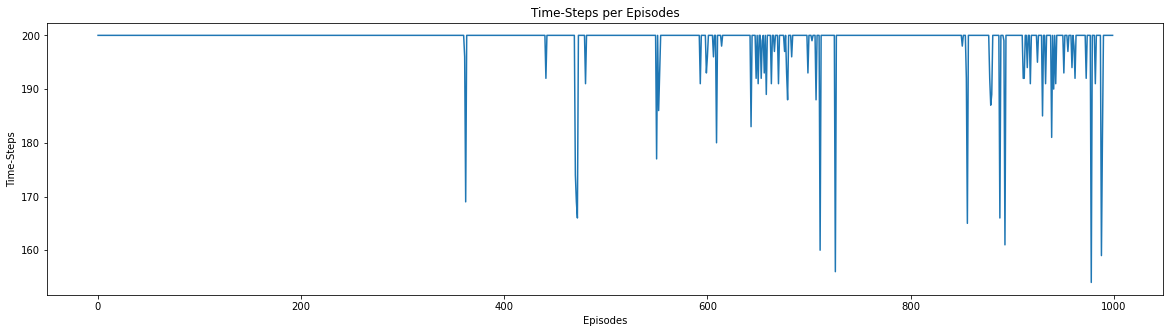

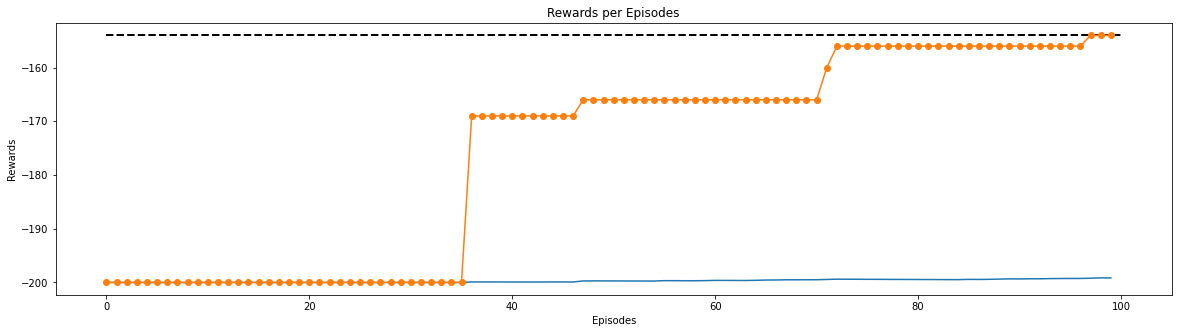

Maximum reward =  -154.0


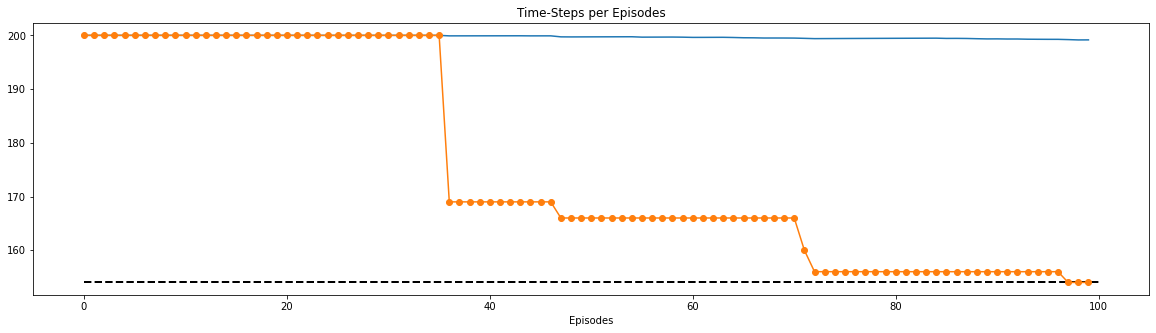

Minimum step =  154


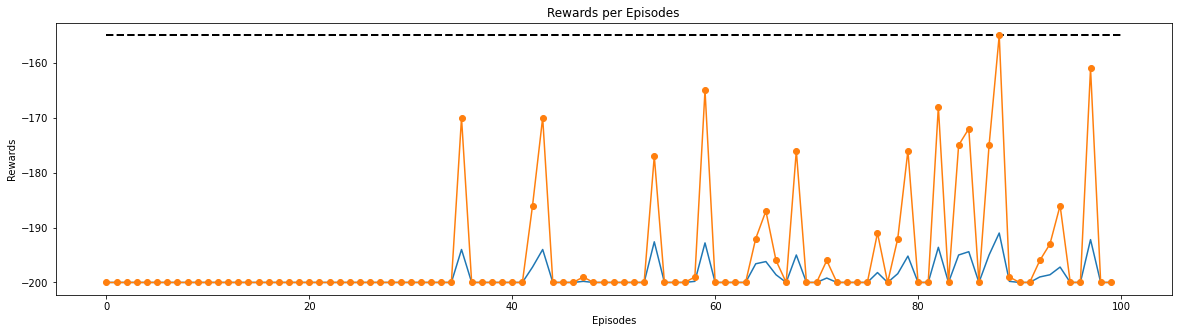

Maximum reward =  -155.0


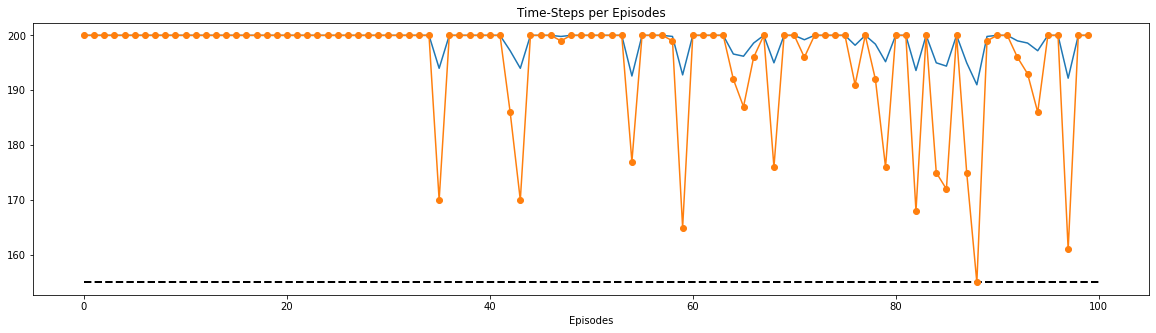

Minimum step =  155


In [9]:
alphas = 0.4
gamma = 0.9
epsilon =0.1
agent=Q_Learning(env,alphas,gamma,epsilon)
learned_policy=train(agent, env)

Episode#:0 reward:-200.0 best_reward:-200.0 eps:0.004 TimeStep:200
Episode#:1 reward:-200.0 best_reward:-200.0 eps:0.004 TimeStep:200
Episode#:2 reward:-200.0 best_reward:-200.0 eps:0.004 TimeStep:200
Episode#:3 reward:-200.0 best_reward:-200.0 eps:0.004 TimeStep:200
Episode#:4 reward:-200.0 best_reward:-200.0 eps:0.004 TimeStep:200
Episode#:5 reward:-200.0 best_reward:-200.0 eps:0.004 TimeStep:200
Episode#:6 reward:-200.0 best_reward:-200.0 eps:0.004 TimeStep:200
Episode#:7 reward:-200.0 best_reward:-200.0 eps:0.004 TimeStep:200
Episode#:8 reward:-200.0 best_reward:-200.0 eps:0.004 TimeStep:200
Episode#:9 reward:-200.0 best_reward:-200.0 eps:0.004 TimeStep:200
Episode#:10 reward:-200.0 best_reward:-200.0 eps:0.004 TimeStep:200
Episode#:11 reward:-200.0 best_reward:-200.0 eps:0.004 TimeStep:200
Episode#:12 reward:-200.0 best_reward:-200.0 eps:0.004 TimeStep:200
Episode#:13 reward:-200.0 best_reward:-200.0 eps:0.004 TimeStep:200
Episode#:14 reward:-200.0 best_reward:-200.0 eps:0.004 Tim

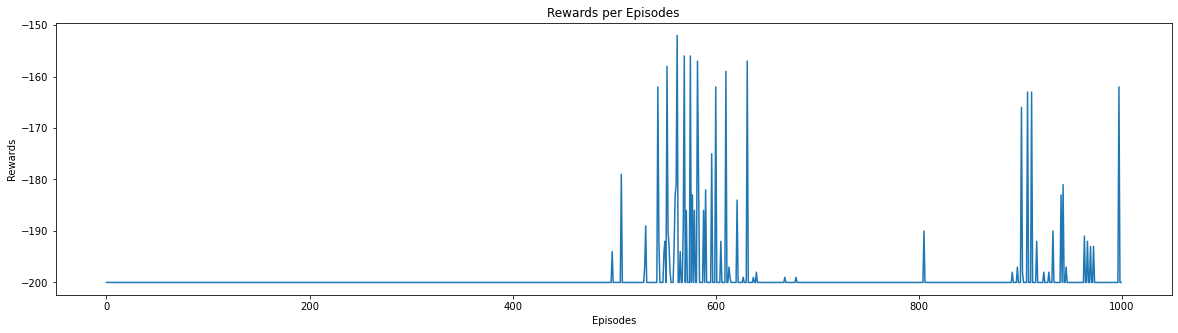

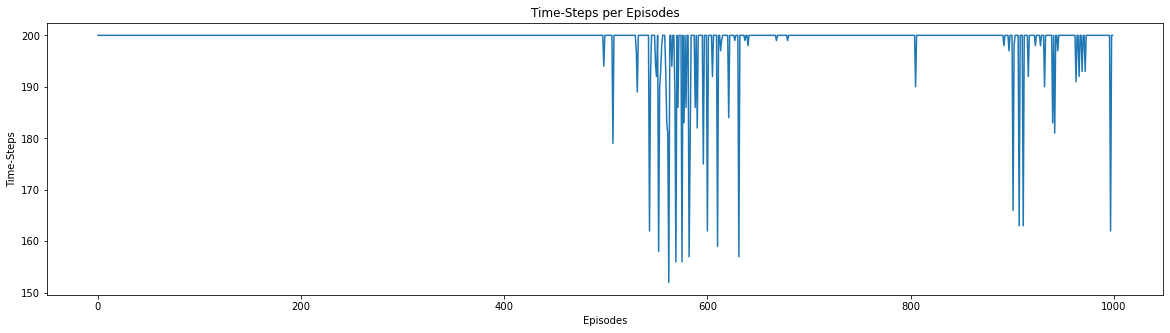

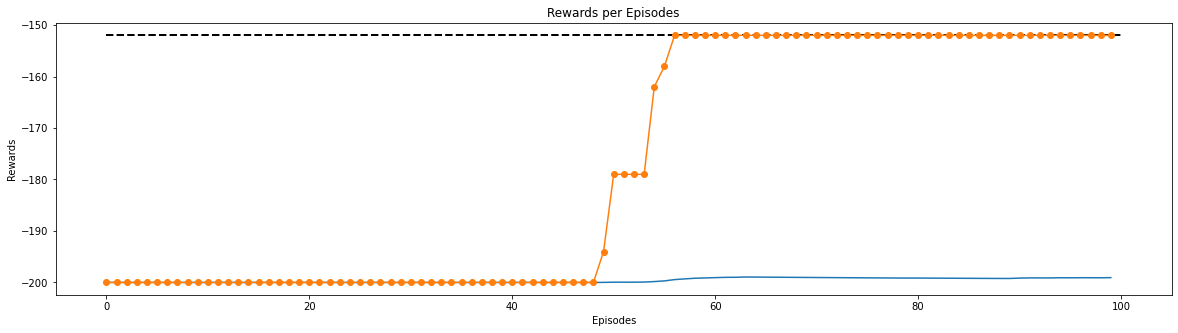

Maximum reward =  -152.0


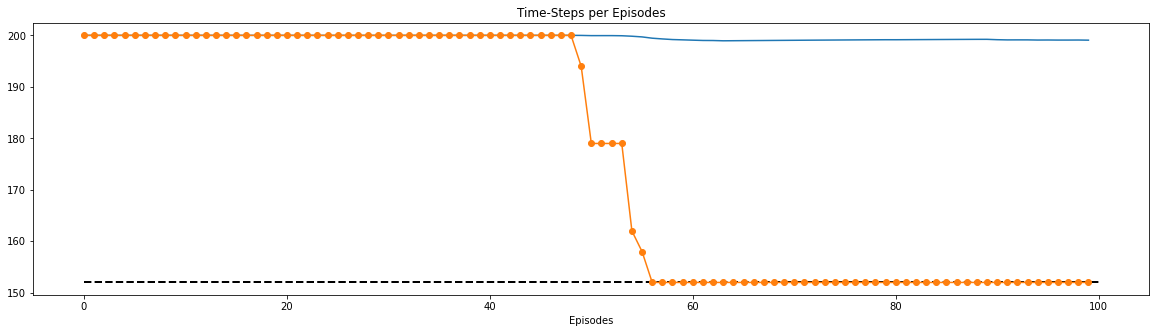

Minimum step =  152


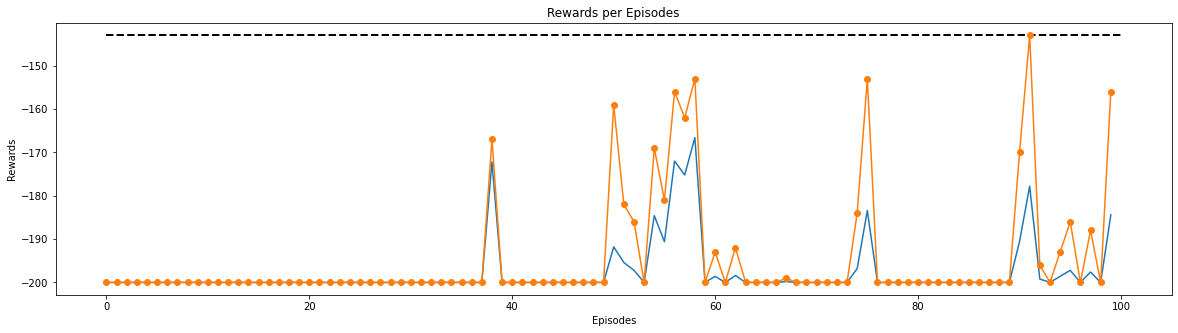

Maximum reward =  -143.0


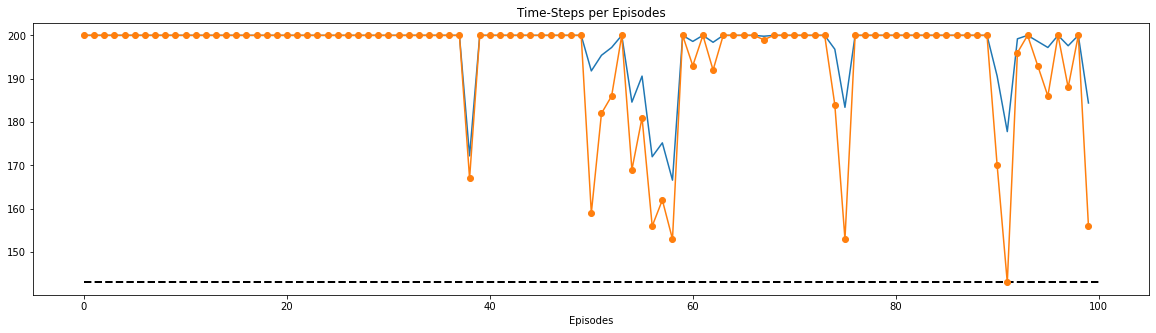

Minimum step =  143


In [9]:
alphas = 0.4
gamma = 0.9
epsilon =0.004
agent=Q_Learning(env,alphas,gamma,epsilon)
learned_policy=train(agent, env)

Episode#:0 reward:-200.0 best_reward:-200.0 eps:0.004 TimeStep:200
Episode#:1 reward:-200.0 best_reward:-200.0 eps:0.004 TimeStep:200
Episode#:2 reward:-200.0 best_reward:-200.0 eps:0.004 TimeStep:200
Episode#:3 reward:-200.0 best_reward:-200.0 eps:0.004 TimeStep:200
Episode#:4 reward:-200.0 best_reward:-200.0 eps:0.004 TimeStep:200
Episode#:5 reward:-200.0 best_reward:-200.0 eps:0.004 TimeStep:200
Episode#:6 reward:-200.0 best_reward:-200.0 eps:0.004 TimeStep:200
Episode#:7 reward:-200.0 best_reward:-200.0 eps:0.004 TimeStep:200
Episode#:8 reward:-200.0 best_reward:-200.0 eps:0.004 TimeStep:200
Episode#:9 reward:-200.0 best_reward:-200.0 eps:0.004 TimeStep:200
Episode#:10 reward:-200.0 best_reward:-200.0 eps:0.004 TimeStep:200
Episode#:11 reward:-200.0 best_reward:-200.0 eps:0.004 TimeStep:200
Episode#:12 reward:-200.0 best_reward:-200.0 eps:0.004 TimeStep:200
Episode#:13 reward:-200.0 best_reward:-200.0 eps:0.004 TimeStep:200
Episode#:14 reward:-200.0 best_reward:-200.0 eps:0.004 Tim

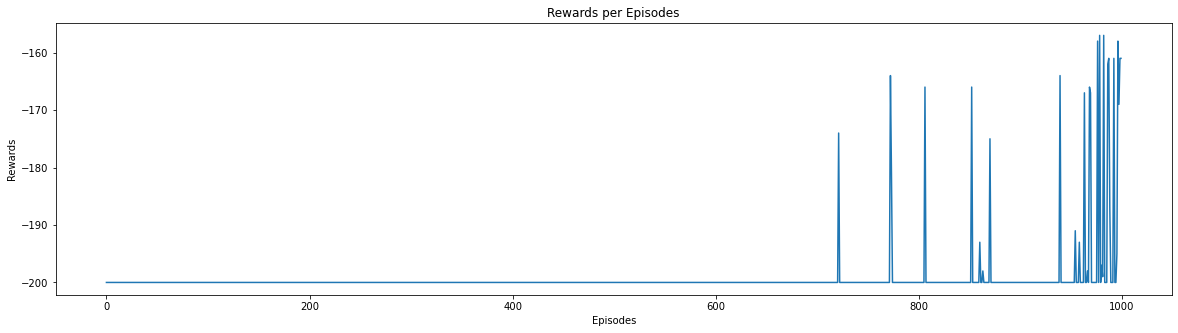

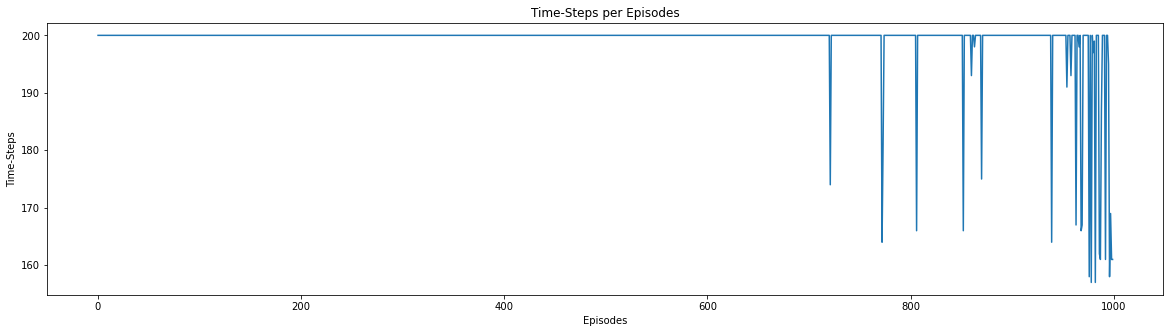

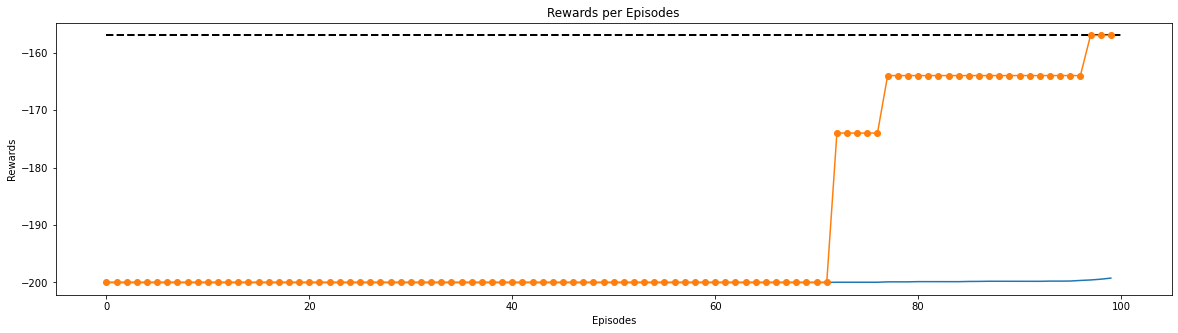

Maximum reward =  -157.0


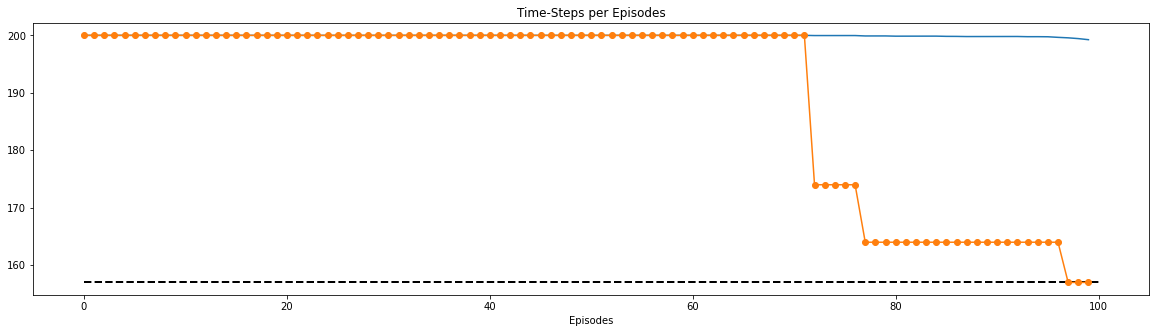

Minimum step =  157


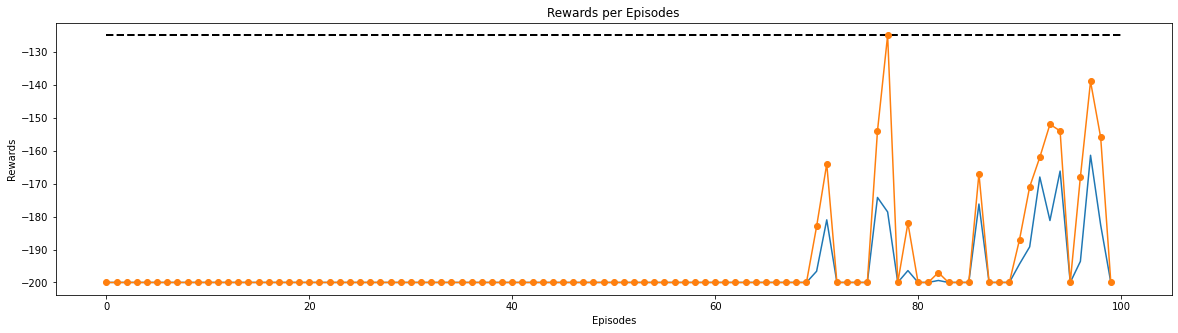

Maximum reward =  -125.0


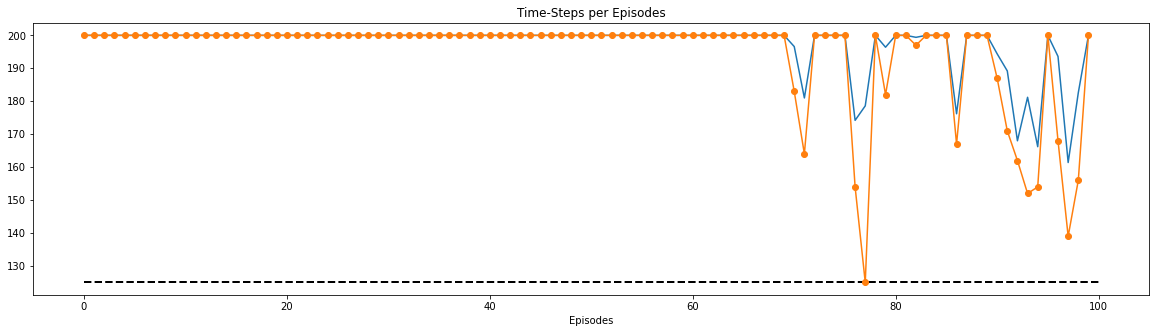

Minimum step =  125


In [9]:
alphas = 0.2
gamma = 0.9
epsilon =0.004
agent=Q_Learning(env,alphas,gamma,epsilon)
learned_policy=train(agent, env)